In [2]:
# Import du jeu de donnée
import pandas as pd
import numpy as np

# copy on write

df = pd.read_csv('fr.openfoodfacts.org.products.csv',sep = '\t',low_memory=False)
# On enlève les colonnes avec moins de 10% de valeurs présentes
df2_under_10 = df.dropna(thresh=0.2*df.shape[0], axis=1)
# On retire les doublons pour la catégorie code et on garde le premier
df2_under_10 = df2_under_10.drop_duplicates(subset='code', keep='first')
# Les pnns_groups_1 regroupe les différentes catégories de produits, cependant tout n'est pas orthographié de la même manière
df3_pnns = df2_under_10.copy()
# Nettoyage des valeurs de pnns_groups_1, enlever les - et mettre en majuscule, remplacer Unknown par NaN
df3_pnns['pnns_groups_1'] = df3_pnns['pnns_groups_1'].str.replace('-',' ').str.capitalize().replace('Unknown',np.nan)

Nous allons réaliser des box plots en fonction des data que nous avons et par catégorie pour voir si l'on peut prédire le jeu de donnée. A en juger par la matrice de missing no. Une bonne moitié d'entre eux sont présent malgré la présence des _100g. Peut être qu'une méthode de regression logistique pourrait fonctionner. On va réaliser quelques analyses complémentaires pour voir à l'oeil s'il y a quelques variations visuellement intéressantes.

In [3]:
# Se débarasser des valeurs que l'on utilisera pas pour notre analyse (J'ai déjà réalisé le boxplot avec df3_pnns avant, et certaines données ne servait à rien, j'ai donc décidé d'itérer les graphiques qui viendront après avec df4 et df5)
df4_drop = df3_pnns.drop(columns=['url', 'creator', 'created_t', 'created_datetime',
       'last_modified_t', 'last_modified_datetime', 'product_name', 'quantity', 'packaging', 'packaging_tags', 'brands',
       'brands_tags', 'categories', 'categories_tags', 'categories_fr', 'countries',
       'countries_tags', 'countries_fr', 'ingredients_text', 'serving_size',
       'additives_n', 'additives', 'additives_tags', 'additives_fr',
       'ingredients_from_palm_oil_n',
       'ingredients_that_may_be_from_palm_oil_n', 'nutrition_grade_fr', 'pnns_groups_2', 'states', 'states_tags', 'states_fr',
       'main_category', 'main_category_fr', 'image_url', 'image_small_url', 'nutrition-score-uk_100g'])

In [4]:
import numpy as np

df5_IQR = df4_drop.copy()

for category in df5_IQR['pnns_groups_1'].unique():
    category_data = df5_IQR[df5_IQR['pnns_groups_1'] == category]
    for col in df5_IQR.select_dtypes(include=['float64']).columns:
        Q1 = category_data[col].quantile(0.25)
        Q3 = category_data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Remplacement des valeurs aberrantes par NaN pour la catégorie et la colonne courantes
        df5_IQR.loc[(df5_IQR['pnns_groups_1'] == category) & 
                    ((df5_IQR[col] < lower_bound) | (df5_IQR[col] > upper_bound)), col] = np.nan

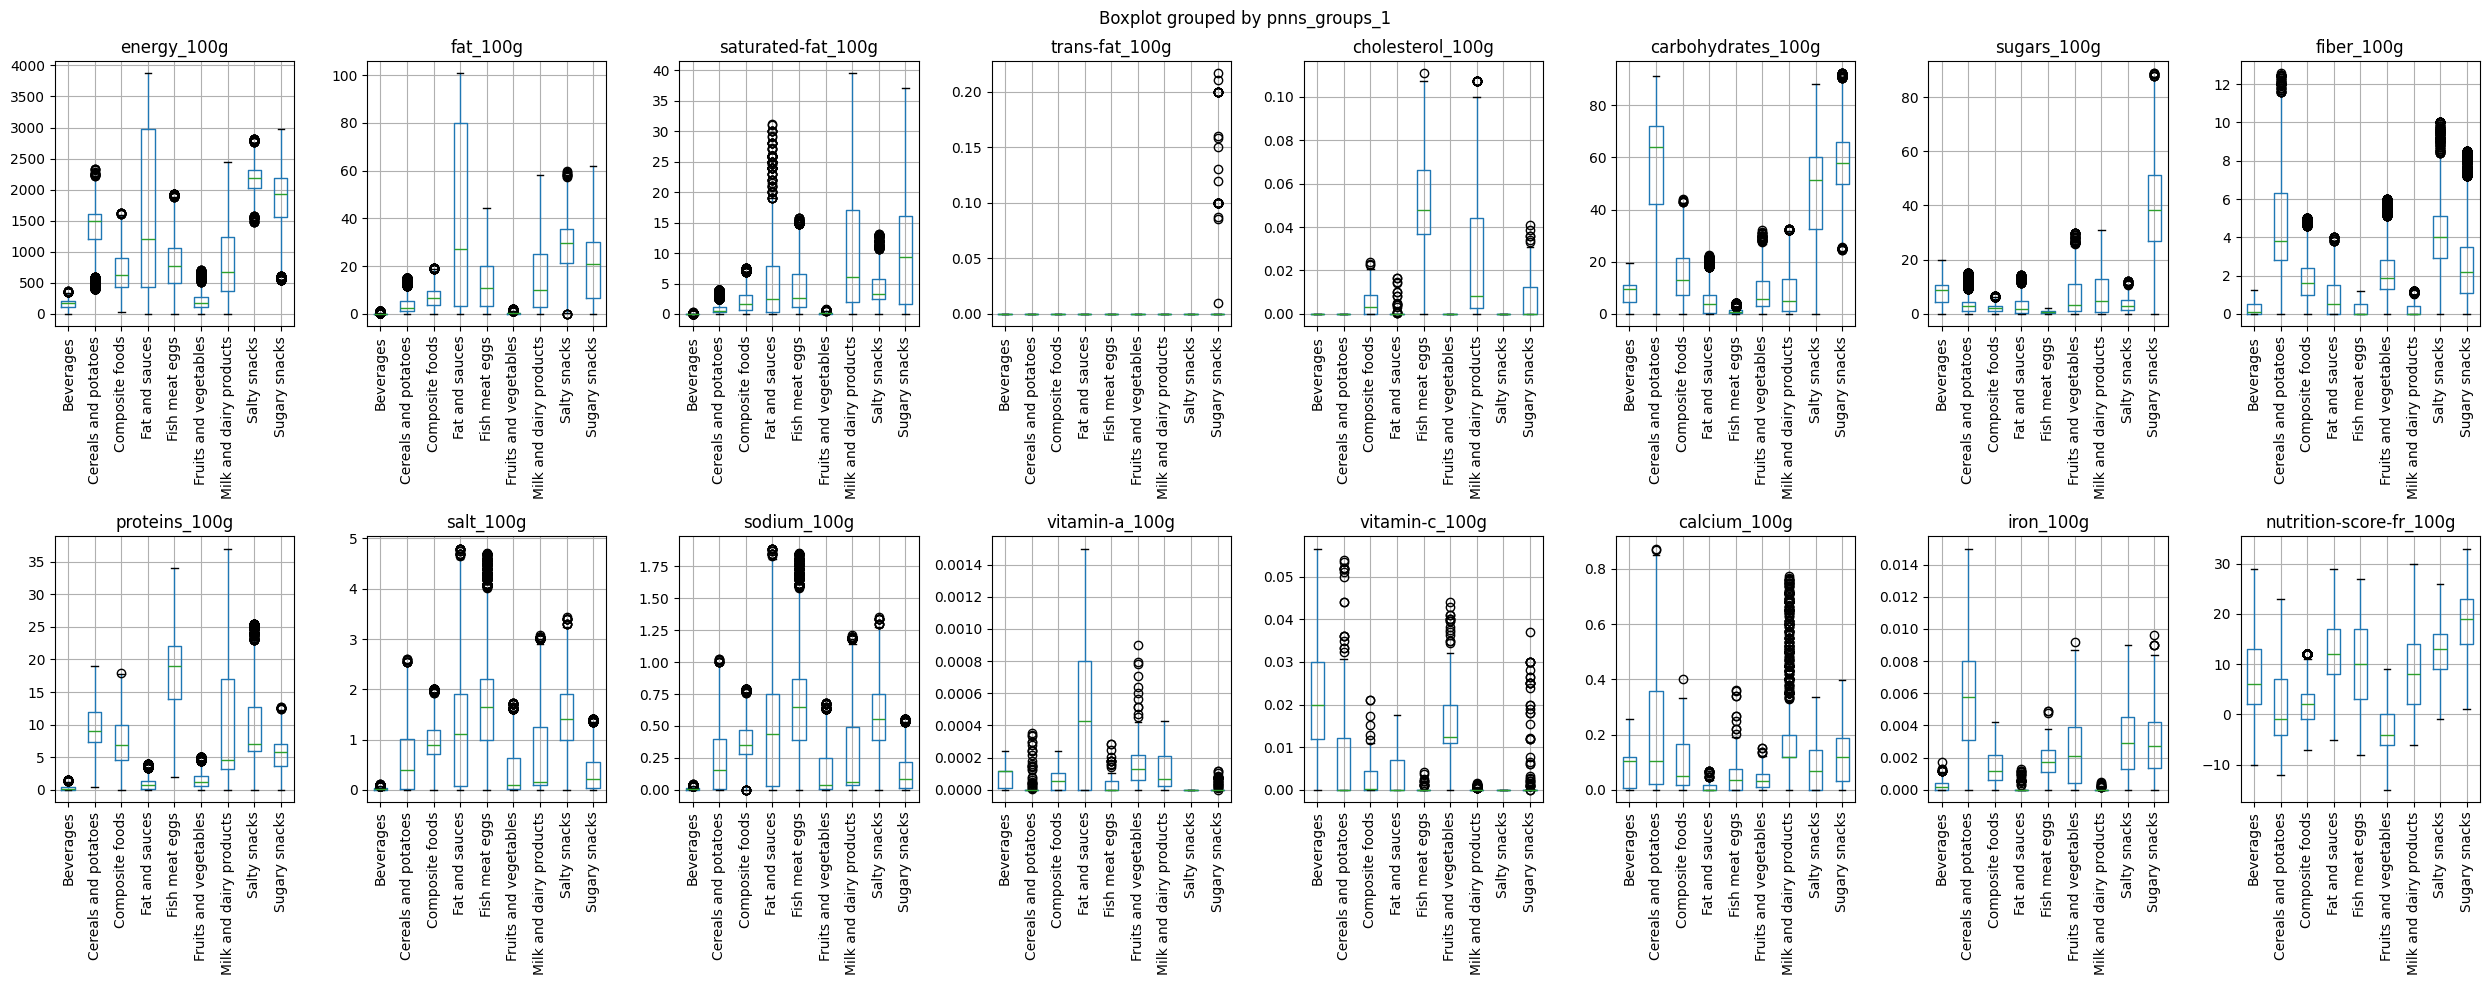

In [5]:
import matplotlib.pyplot as plt
# On refait les boxplots avec df5_IQR
num_cols = 8
num_rows = int(np.ceil(len(df5_IQR.select_dtypes(include=['float64']).columns) / num_cols))

fig, axes = plt.subplots(num_rows, num_cols, figsize=(25, 5*num_rows))
axes = axes.flatten()

for i, col in enumerate(df5_IQR.select_dtypes(include=['float64']).columns):
    df5_IQR.boxplot(column=col, by='pnns_groups_1', ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_xlabel('')
    axes[i].tick_params(axis='x', labelrotation=90)

for j in range(i+1, num_cols*num_rows):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show()    

Les outliers ont été efficacement réduits en utilisant l'IQR par groupe PNNS, c'est plus propre pour réaliser une analyse.
Les groupes de energy_100g, fat_100g, et sugars_100g varient significativement entre les catégories, ce qui permet d'observer des différences claires entre les groupes.

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import plotly.express as px
import plotly.graph_objects as go
from mpl_toolkits.mplot3d import Axes3D

# Suppression des valeurs manquantes
df6_kmeans = df5_IQR.copy()
df6_kmeans = df6_kmeans.dropna()

# On ne garde que les colonnes numériques
df6_kmeans = df6_kmeans.select_dtypes(include=['float64'])

# K-means clustering
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(df6_kmeans)

labels = kmeans.predict(df6_kmeans)
centroids = kmeans.cluster_centers_

# Standardisation des données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df6_kmeans)
X_scaled = pd.DataFrame(X_scaled, columns=df6_kmeans.columns)

# PCA
pca = PCA(n_components=6)
X_proj = pca.fit_transform(X_scaled)
X_proj = pd.DataFrame(X_proj, columns=["F1", "F2", "F3", "F4", "F5", "F6"])

# Projection des centroides
centroids_scaled = scaler.transform(pd.DataFrame(centroids, columns=df6_kmeans.columns))
centroids_proj = pca.transform(centroids_scaled)
centroids_proj = pd.DataFrame(centroids_proj, 
                              columns=["F1", "F2", "F3", "F4", "F5", "F6"], 
                              index=["cluster_0", "cluster_1", "cluster_2", "cluster_3", "cluster_4"])

# Création du tableau des coefficients des composantes principales
components_df = pd.DataFrame(
    np.round(pca.components_, 4), 
    columns=df6_kmeans.columns, 
    index=["F1", "F2", "F3", "F4", "F5", "F6"]
)

# Formatage des valeurs pour mettre en gras celles >= |0.40|
def format_value(value):
    if abs(value) >= 0.4:
        return f'<b>{value}</b>'
    else:
        return f'{value}'

formatted_components_df = components_df.applymap(format_value)

# Affichage du tableau des coefficients
fig = go.Figure(data=[go.Table(
    header=dict(values=['Composante'] + list(components_df.columns),
                fill_color='paleturquoise',
                align='left'),
    cells=dict(values=[formatted_components_df.index] + [formatted_components_df[col] for col in formatted_components_df.columns],
               fill_color='lavender',
               align='left',
               format=['']*len(formatted_components_df.columns))
)])

fig.update_layout(title='Impact des variables sur les composantes principales')
fig.show()

# Création du graphique 3D amélioré
fig = px.scatter_3d(
    x=X_proj.iloc[:, 0],
    y=X_proj.iloc[:, 1],
    z=X_proj.iloc[:, 2],
    color=labels,
    labels={'x': 'F1', 'y': 'F2', 'z': 'F3', 'color': 'Cluster'},
    title='Projection 3D des trois premières composantes principales',
    color_continuous_scale=px.colors.sequential.Viridis
)

# Ajout des centroides
fig.add_scatter3d(
    x=centroids_proj.iloc[:, 0],
    y=centroids_proj.iloc[:, 1],
    z=centroids_proj.iloc[:, 2],
    mode='markers',
    marker=dict(size=10, color='black', symbol='x'),
    name='Centroides'
)

# Personnalisation des axes et des légendes
fig.update_layout(
    scene=dict(
        xaxis=dict(title='F1'),
        yaxis=dict(title='F2'),
        zaxis=dict(title='F3')
    ),
    legend=dict(
        title='Clusters',
        itemsizing='constant'
    )
)

# Affichage du graphique
fig.show()


C:\Users\Richard\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:493: UserWarning:

X does not have valid feature names, but PCA was fitted with feature names

C:\Users\Richard\AppData\Local\Temp\ipykernel_384\21766415.py:56: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.

